In [16]:
"""
Video Fine-Tuning on Videos using a Memory-Efficient Generator
- Loads frames on-the-fly from disk (no full dataset in RAM)
- ResNet50 (feature extractor) + LSTM (temporal modeling)
- Fine-tunes last layers (configurable) or full network
- Handles variable-length videos by truncation/padding to MAX_FRAMES

Usage:
1) Edit DATASET_DIR and TEST_DIR to your folders (each has class subfolders, each subfolder contains video files)
2) (Optional) Set UNFREEZE_LAST to how many ResNet50 layers you want to train. Set to None to train all layers.
3) Run the script. It will train directly with fine-tuning.

Notes:
- OpenCV is used for decoding; avoid use_multiprocessing=True with OpenCV.
- If you have few videos, consider lower batch size (e.g., 2) to fit GPU RAM.
- Works with .mp4, .avi, .mov, .mkv by default; extend VIDEO_EXTS if needed.
"""

import os
import cv2
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from typing import List, Tuple

# ======================
# Config
# ======================
IMG_HEIGHT = 224
IMG_WIDTH = 224
MAX_FRAMES = 20
NUM_CLASSES = None  # will be inferred from folders
BATCH_SIZE = 4
SEED = 42

# Data paths (EDIT THESE)
DATASET_DIR = r"C:\\Users\\DAR-MG\\Documents\\internship_cellula\\video task\\Shop DataSet"
TEST_DIR    = r"C:\\Users\\DAR-MG\\Documents\\internship_cellula\\video task\\test"

# Fine-tuning config
UNFREEZE_LAST = 50   # set to None to train all layers, or an int to unfreeze last N layers
BASE_LR = 1e-5       # small LR for fine-tuning
EPOCHS = 10

# IO config
VIDEO_EXTS = {".mp4", ".avi", ".mov", ".mkv", ".MP4", ".AVI", ".MOV", ".MKV"}

# ======================
# Utilities
# ======================

def list_videos_by_class(root_dir: str) -> Tuple[pd.DataFrame, dict]:
    """Scan a directory with structure: root/class_name/*.mp4 and build a dataframe.
    Returns df with columns [tag, video_path] and a label_map dict.
    """
    items: List[Tuple[str, str]] = []
    class_names = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    class_names = sorted(class_names)
    label_map = {cls: i for i, cls in enumerate(class_names)}

    for cls in class_names:
        cls_dir = os.path.join(root_dir, cls)
        for fname in os.listdir(cls_dir):
            ext = os.path.splitext(fname)[1]
            if ext in VIDEO_EXTS:
                items.append((cls, os.path.join(cls_dir, fname)))

    df = pd.DataFrame(items, columns=["tag", "video_path"])
    return df, label_map


def set_global_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


# ======================
# Video Loader
# ======================

def load_video_frames(path: str, max_frames: int = MAX_FRAMES, size: Tuple[int, int] = (IMG_WIDTH, IMG_HEIGHT)) -> np.ndarray:
    """Load up to max_frames frames, resize to size, normalize [0,1], pad with zeros if shorter."""
    cap = cv2.VideoCapture(path)
    frames: List[np.ndarray] = []
    try:
        if not cap.isOpened():
            # Return black clip if unreadable
            return np.zeros((max_frames, size[1], size[0], 3), dtype=np.float32)
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, size)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = frame.astype(np.float32) / 255.0
            frames.append(frame)
            if len(frames) >= max_frames:
                break
    finally:
        cap.release()

    # Pad if shorter
    if len(frames) < max_frames:
        pad = np.zeros((max_frames - len(frames), size[1], size[0], 3), dtype=np.float32)
        frames = frames + [pad[i] for i in range(pad.shape[0])]

    # Ensure shape (MAX_FRAMES, H, W, 3)
    arr = np.asarray(frames, dtype=np.float32)
    if arr.shape[0] > max_frames:
        arr = arr[:max_frames]
    return arr



In [17]:

# ======================
# Data Generator (Keras Sequence)
# ======================
class VideoSequence(Sequence):
    def __init__(self, df: pd.DataFrame, label_map: dict, batch_size: int = BATCH_SIZE,
                 shuffle: bool = True):
        self.df = df.reset_index(drop=True)
        self.label_map = label_map
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self) -> int:
        return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, idx: int):
        batch_indexes = self.indexes[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch_paths = self.df.loc[batch_indexes, "video_path"].tolist()
        batch_tags  = self.df.loc[batch_indexes, "tag"].tolist()

        X = np.zeros((len(batch_paths), MAX_FRAMES, IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.float32)
        y = np.zeros((len(batch_paths),), dtype=np.int64)

        for i, (p, t) in enumerate(zip(batch_paths, batch_tags)):
            X[i] = load_video_frames(p)
            y[i] = self.label_map[t]

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)



In [18]:

# ======================
# Model: ResNet50 + LSTM (Fine-Tuning)
# ======================

def build_model(num_classes: int):
    base_cnn = tf.keras.applications.ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )

    # Fine-tuning setup
    if UNFREEZE_LAST is None:
        base_cnn.trainable = True
    else:
        base_cnn.trainable = True
        for layer in base_cnn.layers[:-UNFREEZE_LAST]:
            layer.trainable = False

    model = models.Sequential([
        layers.TimeDistributed(base_cnn, input_shape=(MAX_FRAMES, IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.TimeDistributed(layers.GlobalAveragePooling2D()),
        layers.LSTM(64),
        layers.Dense(64, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(BASE_LR),
        metrics=["accuracy"]
    )
    return model



In [20]:

# ======================
# Main Training
# ======================
if __name__ == "__main__":
    set_global_seed(SEED)

    # Build dataframes and label maps
    train_df, label_map = list_videos_by_class(DATASET_DIR)
    test_df,  _        = list_videos_by_class(TEST_DIR)

    num_classes = len(label_map)
    print("Label map:", label_map)

    # Generators
    train_gen = VideoSequence(train_df, label_map, batch_size=BATCH_SIZE, shuffle=True)
    val_gen   = VideoSequence(test_df,  label_map, batch_size=BATCH_SIZE, shuffle=False)

    # Model
    model = build_model(num_classes)
    model.summary()

    # Callbacks
    ckpt_path = os.path.join(os.getcwd(), "video_finetune_best.keras")
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, verbose=1),
        tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)
    ]
    history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    verbose=1,
    shuffle=False
)


    # Save final model
    model.save("video_finetuned_final.keras")
    print("Training finished. Best model at:", ckpt_path)


Label map: {'non shop lifters': 0, 'shop lifters': 1}


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_2              │ (None, 20, 7, 7, 2048) │    23,587,712 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 20, 2048)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │       540,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,132,930 (92.06 MB)

 Trainable params: 17,495,746 (66.74 MB)

 Non-trainable params: 6,637,184 (25.32 MB)

c:\Users\DAR-MG\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7524 - loss: 0.5120

c:\Users\DAR-MG\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


212/212 ━━━━━━━━━━━━━━━━━━━━ 1690s 7s/step - accuracy: 0.7526 - loss: 0.5118 - val_accuracy: 0.8333 - val_loss: 0.4149
Epoch 2/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 1436s 7s/step - accuracy: 0.8698 - loss: 0.3126 - val_accuracy: 0.6667 - val_loss: 0.4274
Epoch 3/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 1329s 6s/step - accuracy: 0.8778 - loss: 0.2897 - val_accuracy: 0.5833 - val_loss: 1.2333
Epoch 4/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 1341s 6s/step - accuracy: 0.8861 - loss: 0.2718 - val_accuracy: 0.4167 - val_loss: 1.5809
Epoch 5/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 1457s 7s/step - accuracy: 0.8833 - loss: 0.2831 - val_accuracy: 0.6667 - val_loss: 0.5443
Epoch 6/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 1480s 7s/step - accuracy: 0.9185 - loss: 0.2058 - val_accuracy: 1.0000 - val_loss: 0.1308
Epoch 7/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 1535s 7s/step - accuracy: 0.8990 - loss: 0.2446 - val_accuracy: 1.0000 - val_loss: 0.0989
Epoch 8/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 1416s 7s/step - accuracy: 0.9372 - loss: 0.1802 - val_accurac

In [29]:
loss, acc = model.evaluate(train_gen, verbose=1)
print(f"Test Accuracy: {acc*100:.2f}%")
print(f"Test Loss: {loss:.4f}")


212/212 ━━━━━━━━━━━━━━━━━━━━ 812s 4s/step - accuracy: 0.8934 - loss: 0.2107
Test Accuracy: 91.01%
Test Loss: 0.1885


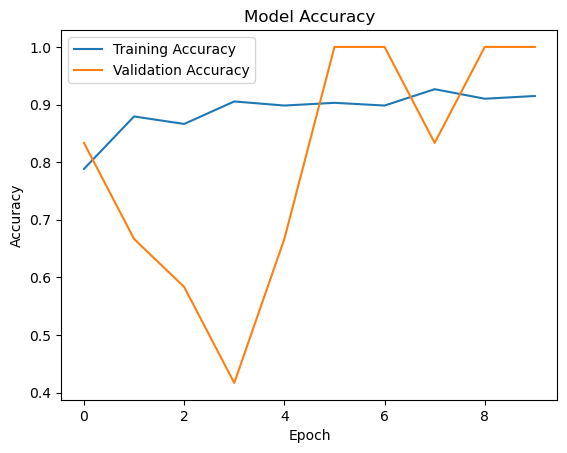

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
import cv2
import numpy as np

# نفس دالة تحميل الفيديو اللي استخدمناها في التدريب
def load_video_for_test(path, max_frames=MAX_FRAMES, resize=(IMG_WIDTH, IMG_HEIGHT)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, resize)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) / 255.0
            frames.append(frame)
            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    while len(frames) < MAX_FRAMES:
        frames.append(np.zeros((IMG_HEIGHT, IMG_WIDTH, 3)))
    return np.array(frames)[:MAX_FRAMES]

# تحميل الفيديو المراد اختباره
video_path = r"C:\Users\DAR-MG\Documents\internship_cellula\video task\test\non shop lifters\shop_lifter_n_99_1.mp4"
video_data = load_video_for_test(video_path)

# إضافة بعد batch
video_data = np.expand_dims(video_data, axis=0)  # shape: (1, MAX_FRAMES, H, W, 3)

# عمل التنبؤ
pred = model.predict(video_data)
pred_class = np.argmax(pred, axis=1)[0]

# عكس الترميز للـ label
reverse_label_map = {v: k for k, v in label_map.items()}
print(f"🎯 Prediction: {reverse_label_map[pred_class]} (confidence: {np.max(pred):.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 39s 39s/step
🎯 Prediction: non shop lifters (confidence: 0.85)


In [30]:
model.save("video_finetuned_final_noopt.keras", include_optimizer=False)
